In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, RocCurveDisplay, ConfusionMatrixDisplay, plot_roc_curve, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV


In [2]:
X_train = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\X_train_bad')
X_test = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\X_test_bad')
y_train = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\y_train_bad')
y_test = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\y_test_bad')


# Classification: Good vs Bad
- Logistic Regression: as a base line. set param class_weight=balenced
- KNN
- Random Forest: Boosted, and other variants

Bad is defined as Has been canceled or has given notice that it will br canceled

Minimizing false positives(false bad prediction)

Heavily inblalenced data, accuracy not a helpful measure

Split train and test set to give equal proportion of good and bad? (DONE)

Oversampling/ Undersampling/ hybrid sampling ?

Drop Dead people??

Maybe this https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

Wouldn't preprocessing also be in this notebook?

#### Entropy vs Gini for each

#### Hyperparam tuning comes last?



In [3]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.ravel()
y_test= y_test.values.ravel()

In [4]:
from imblearn.over_sampling import SMOTE, ADASYN

X_smo, y_smo = SMOTE(random_state=2).fit_resample(X_train, y_train)

X_ada, y_ada = ADASYN(random_state=2).fit_resample(X_train, y_train)

In [5]:
#some helper functions for my sanity

def classify(model, X_train, y_train, X_test=X_test ):
    '''Takes in model, X_train, X_test, y_train
    returns tuple of (fit model, y_pred, predict_proba[:,1])'''
    
    m = model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    prob = model.predict_proba(X_test)[:,1]
    
    return (m, pred, prob)

def model_cv(model, X=X_train, y=y_train, cv=5, scoring='roc_auc'):
    '''takes the model, X_train, y_train, cv(=5), scoring(='roc_auc')
    returns array of scores, prints array, mean, std of scores scores'''
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    print(str(model), 'no resampling')
    print('The scores are', scores)
    print('The mean is', scores.mean())
    print('The STD is', scores.std())
    
    return (scores)

def model_cv_smo(model, X=X_smo, y=y_smo, cv=5, scoring='roc_auc'):
    '''takes the model, X_train, y_train, cv(=5), scoring(='roc_auc')
    returns array of scores, prints array, mean, std of scores scores'''
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    print(str(model), 'w/ SMOTE')
    print('The scores are', scores)
    print('The mean is', scores.mean())
    print('The STD is', scores.std())
    
    return (scores)

def model_cv_ada(model, X=X_ada, y=y_ada, cv=5, scoring='roc_auc'):
    '''takes the model, X_train, y_train, cv(=5), scoring(='roc_auc')
    returns array of scores, prints array, mean, std of scores scores'''
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    print(str(model), 'w/ ADASYN')
    print('The scores are', scores)
    print('The mean is', scores.mean())
    print('The STD is', scores.std())
    
    return (scores)
    
def find_threshold(probs, y_test=y_test):
    '''takes predict_proba[:,1] for certain model, y_test is set because imonly doing this for the one y_test
    uses Youdens J statistic
    prints the threshold
    returns new predictions given the threshold'''
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    gmeans = tpr - fpr
    
    thresh = thresholds[np.argmax(gmeans)]
    
    print('The threshold is', thresh)
    return (probs >= thresh).astype(int)


In [6]:
from sklearn.linear_model import LogisticRegression

lr, pred_lr, prob_lr= classify(LogisticRegression(), X_train, y_train)

In [7]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6201
           1       0.00      0.00      0.00       103

    accuracy                           0.98      6304
   macro avg       0.49      0.50      0.50      6304
weighted avg       0.97      0.98      0.98      6304



C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
pred_lr_thsh = find_threshold(prob_lr)

The threshold is 0.021303877941059413


In [9]:
print(classification_report(y_test, pred_lr_thsh))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      6201
           1       0.05      0.74      0.09       103

    accuracy                           0.76      6304
   macro avg       0.52      0.75      0.48      6304
weighted avg       0.98      0.76      0.85      6304



## Logistic Regression

In [10]:
#from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

lr, pred_lr, prob_lr= classify(LogisticRegression(random_state=2, n_jobs=-1), X_train, y_train)

lr_smo, pred_lr_smo, prob_lr_smo= classify(LogisticRegression(random_state=2, n_jobs=-1), X_smo, y_smo)

lr_ada, pred_lr_ada, prob_lr_ada= classify(LogisticRegression(random_state=2, n_jobs=-1), X_ada, y_ada)


In [11]:
print('Regular')
print(classification_report(y_test, pred_lr),'')
print('SMOTE')
print(classification_report(y_test, pred_lr_smo),'')
print('ADASYN')
print(classification_report(y_test, pred_lr_ada),'')

Regular
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6201
           1       0.00      0.00      0.00       103

    accuracy                           0.98      6304
   macro avg       0.49      0.50      0.50      6304
weighted avg       0.97      0.98      0.98      6304
 
SMOTE
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      6201
           1       0.04      0.80      0.08       103

    accuracy                           0.70      6304
   macro avg       0.52      0.75      0.45      6304
weighted avg       0.98      0.70      0.81      6304
 
ADASYN
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      6201
           1       0.04      0.80      0.08       103

    accuracy                           0.70      6304
   macro avg       0.52      0.75      0.45      6304
weighted avg       0.98      0.70      0.81      63

C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


def con_mats(graph_info, y_test=y_test):
    '''accepts list of 3 tuples each with y_pred, title, and axes in that order. and a y_test to test them on
    plots confusion matrixes in a line'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, len(axes), figsize=(20,5))
    
    for pred, title, ax in graph_info:
        cm = confusion_matrix(y_test, pred)
        cm_dis  = ConfusionMatrixDisplay(cm).plot(ax=ax, cmap=plt.cm.Blues)
        cm_dis.ax_.set_title(title)
        
    plt.subplots_adjust(wspace=0.08)
    
    plt.show()



axes = (ax1, ax2, ax3)

this = [(pred_lr, 'Logistic Regression (LR)', ax1), (pred_lr_smo, 'LR w/ SMOTE', ax2), (pred_lr_ada, 'LR w/ ADASYN', ax3)]

con_mats(this, lr_titles)

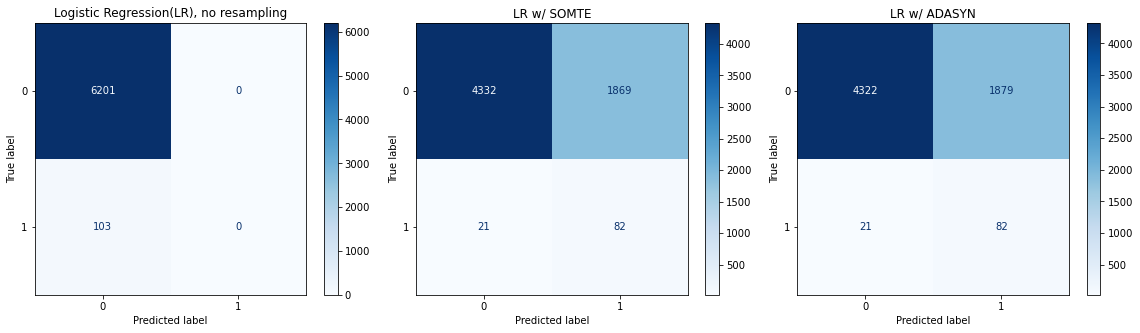

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

cm1 = confusion_matrix(y_test, pred_lr)

cm2 = confusion_matrix(y_test, pred_lr_smo)

cm3 = confusion_matrix(y_test, pred_lr_ada)

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1,cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)
cm3_dis = ConfusionMatrixDisplay(cm3).plot(ax=ax3, cmap=plt.cm.Blues)

ax1.set_title('Logistic Regression(LR), no resampling')
ax2.set_title("LR w/ SOMTE")
ax3.set_title('LR w/ ADASYN')

plt.subplots_adjust(wspace=0.08)

plt.show()


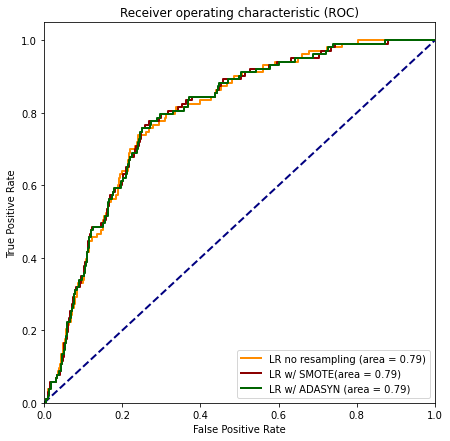

In [13]:
fig = plt.figure(figsize=(7,7))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

fpr, tpr, _ = roc_curve(y_test, prob_lr)
auc = roc_auc_score(y_test, prob_lr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='LR no resampling (area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_lr_smo)
auc = roc_auc_score(y_test, prob_lr_smo)
plt.plot(fpr, tpr, color='darkred', lw=lw, label='LR w/ SMOTE(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_lr_ada)
auc = roc_auc_score(y_test, prob_lr_ada)
plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='LR w/ ADASYN (area = %0.2f)' % auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [14]:

#plot_roc_curve(lr, X_test, y_test)
#plot_roc_curve(lr_smo, X_test, y_test)
#plot_roc_curve(lr_ada, X_test, y_test)

In [15]:
print('No resampling')
model_cv(lr)
print('')
print('SMOTE')
model_cv_smo(lr_smo)
print('')
print('ADASYN')
model_cv_ada(lr_ada)

No resampling
LogisticRegression(n_jobs=-1, random_state=2) no resampling
The scores are [0.77816404 0.75551144 0.74260401 0.7782735  0.77118887]
The mean is 0.765148369909982
The STD is 0.013994877720291888

SMOTE
LogisticRegression(n_jobs=-1, random_state=2) w/ SMOTE
The scores are [0.79405108 0.80324596 0.80291783 0.79256971 0.80272148]
The mean is 0.7991012118942937
The STD is 0.004754287548311572

ADASYN
LogisticRegression(n_jobs=-1, random_state=2) w/ ADASYN
The scores are [0.8001791  0.76681499 0.78118299 0.79756476 0.78778549]
The mean is 0.7867054659840101
The STD is 0.01205619047880789


array([0.8001791 , 0.76681499, 0.78118299, 0.79756476, 0.78778549])

In [16]:
skf = StratifiedKFold(n_splits=5)
print('With Stratified K Fold CV')
print('')
print('No resampling')
model_cv(lr,cv=skf)
print('')
print('SMOTE')
model_cv_smo(lr_smo, cv=skf)
print('')
print('ADASYN')
model_cv_ada(lr_ada, cv=skf)

With Stratified K Fold CV

No resampling
LogisticRegression(n_jobs=-1, random_state=2) no resampling
The scores are [0.77816404 0.75551144 0.74260401 0.7782735  0.77118887]
The mean is 0.765148369909982
The STD is 0.013994877720291888

SMOTE
LogisticRegression(n_jobs=-1, random_state=2) w/ SMOTE
The scores are [0.79405108 0.80324596 0.80291783 0.79256971 0.80272148]
The mean is 0.7991012118942937
The STD is 0.004754287548311572

ADASYN
LogisticRegression(n_jobs=-1, random_state=2) w/ ADASYN
The scores are [0.8001791  0.76681499 0.78118299 0.79756476 0.78778549]
The mean is 0.7867054659840101
The STD is 0.01205619047880789


array([0.8001791 , 0.76681499, 0.78118299, 0.79756476, 0.78778549])

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, prob_lr)
gmeans = tpr - fpr
thresh_lr = thresholds[np.argmax(gmeans)]
pred_lr_thsh = (prob_lr >= thresh_lr).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, prob_lr_smo)
gmeans = tpr - fpr
thresh_lr_smo = thresholds[np.argmax(gmeans)]
pred_lr_smo_thsh = (prob_lr_smo >= thresh_lr_smo).astype(int)

fpr, tpr, thresholds = roc_curve(y_test, prob_lr_ada)
gmeans = tpr - fpr
thresh_lr_ada = thresholds[np.argmax(gmeans)]
pred_lr_ada_thsh = (prob_lr_ada >= thresh_lr_ada).astype(int)

In [18]:
print('Regular')
print(classification_report(y_test, pred_lr_thsh),'')
print('SMOTE')
print(classification_report(y_test, pred_lr_smo_thsh),'')
print('ADASYN')
print(classification_report(y_test, pred_lr_ada_thsh),'')

Regular
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      6201
           1       0.05      0.74      0.09       103

    accuracy                           0.76      6304
   macro avg       0.52      0.75      0.48      6304
weighted avg       0.98      0.76      0.85      6304
 
SMOTE
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      6201
           1       0.05      0.77      0.09       103

    accuracy                           0.74      6304
   macro avg       0.52      0.76      0.47      6304
weighted avg       0.98      0.74      0.84      6304
 
ADASYN
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      6201
           1       0.05      0.76      0.09       103

    accuracy                           0.75      6304
   macro avg       0.52      0.75      0.47      6304
weighted avg       0.98      0.75      0.84      63

## KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

#param_grid = {'n_neighbors':np.arange(1,10)}
#knn_cv= GridSearchCV(knn,param_grid,cv=5)

knn, pred_knn, prob_knn = classify(KNeighborsClassifier(n_jobs=-1), X_train, y_train)

knn_smo, pred_knn_smo, prob_knn_smo= classify(KNeighborsClassifier(n_jobs=-1), X_smo, y_smo)

knn_ada, pred_knn_ada, prob_knn_ada= classify(KNeighborsClassifier(n_jobs=-1), X_ada, y_ada)


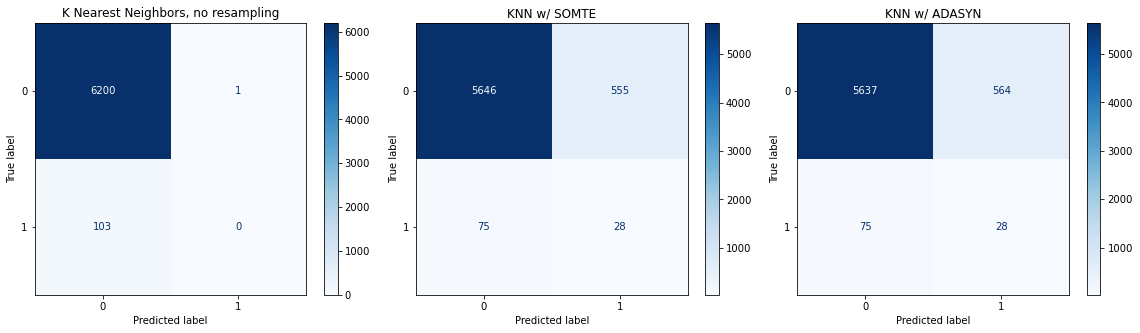

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

cm1 = confusion_matrix(y_test, pred_knn)

cm2 = confusion_matrix(y_test, pred_knn_smo)

cm3 = confusion_matrix(y_test, pred_knn_ada)

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1,cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)
cm3_dis = ConfusionMatrixDisplay(cm3).plot(ax=ax3, cmap=plt.cm.Blues)

ax1.set_title('K Nearest Neighbors, no resampling')
ax2.set_title("KNN w/ SOMTE")
ax3.set_title('KNN w/ ADASYN')

plt.subplots_adjust(wspace=0.08)

plt.show()

In [21]:
#print(classification_report(y_test, y_pred_knn))
#print(classification_report(y_test, y_pred_knn_smo))
#print(classification_report(y_test, y_pred_knn_ada))

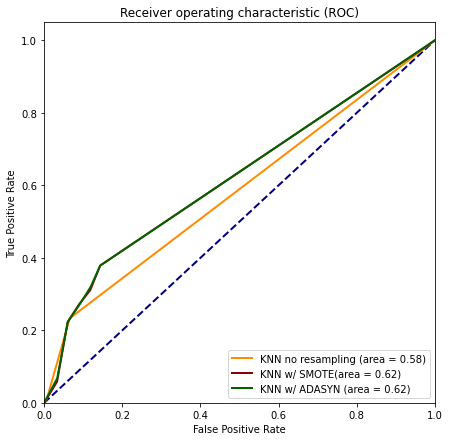

In [22]:
fig = plt.figure(figsize=(7,7))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

fpr, tpr, _ = roc_curve(y_test, prob_knn)
auc = roc_auc_score(y_test, prob_knn)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='KNN no resampling (area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_knn_smo)
auc = roc_auc_score(y_test, prob_knn_smo)
plt.plot(fpr, tpr, color='darkred', lw=lw, label='KNN w/ SMOTE(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_knn_ada)
auc = roc_auc_score(y_test, prob_knn_ada)
plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='KNN w/ ADASYN (area = %0.2f)' % auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [23]:
print('No resampling')
model_cv(knn)
print('')
print('SMOTE')
model_cv_smo(knn)
print('')
print('ADASYN')
model_cv_ada(knn)

No resampling
KNeighborsClassifier(n_jobs=-1) no resampling
The scores are [0.52275446 0.50740566 0.54219076 0.55554327 0.59312348]
The mean is 0.5442035258835973
The STD is 0.029461665435155868

SMOTE
KNeighborsClassifier(n_jobs=-1) w/ SMOTE
The scores are [0.97687197 0.97762994 0.97877923 0.97758873 0.97655673]
The mean is 0.9774853210258637
The STD is 0.0007673682357055403

ADASYN
KNeighborsClassifier(n_jobs=-1) w/ ADASYN
The scores are [0.94117964 0.95949188 0.94914447 0.95128576 0.94815495]
The mean is 0.9498513394823656
The STD is 0.005891915326190552


array([0.94117964, 0.95949188, 0.94914447, 0.95128576, 0.94815495])

In [24]:
skf = StratifiedKFold(n_splits=5)
print('With Stratified K Fold CV')
print('')
print('No resampling')
model_cv(knn,cv=skf)
print('')
print('SMOTE')
model_cv_smo(knn_smo, cv=skf)
print('')
print('ADASYN')
model_cv_ada(knn_ada, cv=skf)

With Stratified K Fold CV

No resampling
KNeighborsClassifier(n_jobs=-1) no resampling
The scores are [0.52275446 0.50740566 0.54219076 0.55554327 0.59312348]
The mean is 0.5442035258835973
The STD is 0.029461665435155868

SMOTE
KNeighborsClassifier(n_jobs=-1) w/ SMOTE
The scores are [0.97687197 0.97762994 0.97877923 0.97758873 0.97655673]
The mean is 0.9774853210258637
The STD is 0.0007673682357055403

ADASYN
KNeighborsClassifier(n_jobs=-1) w/ ADASYN
The scores are [0.94117964 0.95949188 0.94914447 0.95128576 0.94815495]
The mean is 0.9498513394823656
The STD is 0.005891915326190552


array([0.94117964, 0.95949188, 0.94914447, 0.95128576, 0.94815495])

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf, pred_rf, prob_rf = classify(RandomForestClassifier(random_state=2, n_jobs=-1), X_train, y_train)

rf_smo, pred_rf_smo, prob_rf_smo= classify(RandomForestClassifier(random_state=2, n_jobs=-1), X_smo, y_smo)

rf_ada, pred_rf_ada, prob_rf_ada= classify(RandomForestClassifier(random_state=2, n_jobs=-1), X_ada, y_ada)


In [27]:
#print('Regular')
#print(classification_report(y_test, y_pred_clf),'')
#print('SMOTE')
#print(classification_report(y_test, y_pred_clf_smo),'')
#print('ADASYN')
#print(classification_report(y_test, y_pred_clf_ada),'')

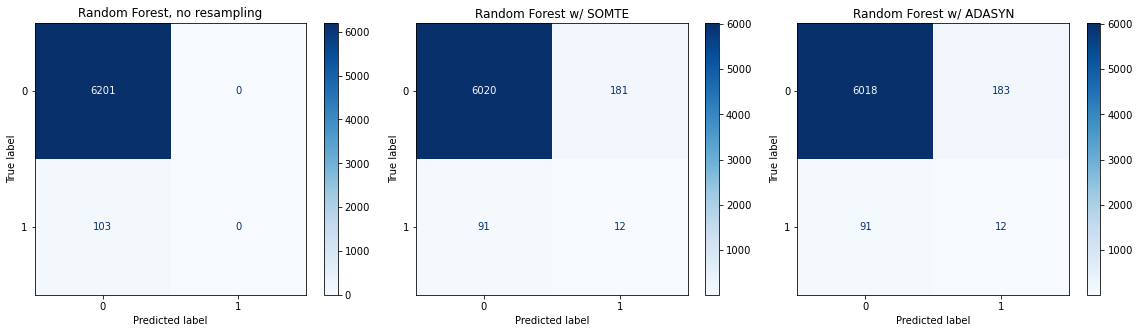

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

cm1 = confusion_matrix(y_test, pred_rf)

cm2 = confusion_matrix(y_test, pred_rf_smo)

cm3 = confusion_matrix(y_test, pred_rf_ada)

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1,cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)
cm3_dis = ConfusionMatrixDisplay(cm3).plot(ax=ax3, cmap=plt.cm.Blues)

ax1.set_title('Random Forest, no resampling')
ax2.set_title("Random Forest w/ SOMTE")
ax3.set_title('Random Forest w/ ADASYN')

plt.subplots_adjust(wspace=0.08)

plt.show()

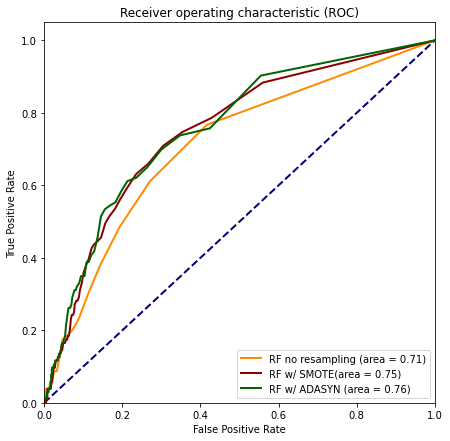

In [29]:
fig = plt.figure(figsize=(7,7))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

fpr, tpr, _ = roc_curve(y_test, prob_rf)
auc = roc_auc_score(y_test, prob_rf)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='RF no resampling (area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_rf_smo)
auc = roc_auc_score(y_test, prob_rf_smo)
plt.plot(fpr, tpr, color='darkred', lw=lw, label='RF w/ SMOTE(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_rf_ada)
auc = roc_auc_score(y_test, prob_rf_ada)
plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='RF w/ ADASYN (area = %0.2f)' % auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [30]:
print('No resampling')
model_cv(rf)
print('')
print('SMOTE')
model_cv_smo(rf_smo)
print('')
print('ADASYN')
model_cv_ada(rf_ada)

No resampling
RandomForestClassifier(n_jobs=-1, random_state=2) no resampling
The scores are [0.66988366 0.6345437  0.66404016 0.65518123 0.62755593]
The mean is 0.6502409369202902
The STD is 0.01650257265369315

SMOTE
RandomForestClassifier(n_jobs=-1, random_state=2) w/ SMOTE
The scores are [0.99419429 0.99761973 0.99819045 0.99817716 0.9978495 ]
The mean is 0.9972062242353583
The STD is 0.0015210507126413417

ADASYN
RandomForestClassifier(n_jobs=-1, random_state=2) w/ ADASYN
The scores are [0.98233287 0.98875003 0.98419093 0.98632255 0.98603573]
The mean is 0.9855264222418321
The STD is 0.002157182684776893


array([0.98233287, 0.98875003, 0.98419093, 0.98632255, 0.98603573])

In [31]:
skf = StratifiedKFold(n_splits=5)
print('With Stratified K Fold CV')
print('')
print('No resampling')
model_cv(rf,cv=skf)
print('')
print('SMOTE')
model_cv_smo(rf_smo, cv=skf)
print('')
print('ADASYN')
model_cv_ada(rf_ada, cv=skf)

With Stratified K Fold CV

No resampling
RandomForestClassifier(n_jobs=-1, random_state=2) no resampling
The scores are [0.66988366 0.6345437  0.66404016 0.65518123 0.62755593]
The mean is 0.6502409369202902
The STD is 0.01650257265369315

SMOTE
RandomForestClassifier(n_jobs=-1, random_state=2) w/ SMOTE
The scores are [0.99419429 0.99761973 0.99819045 0.99817716 0.9978495 ]
The mean is 0.9972062242353583
The STD is 0.0015210507126413417

ADASYN
RandomForestClassifier(n_jobs=-1, random_state=2) w/ ADASYN
The scores are [0.98233287 0.98875003 0.98419093 0.98632255 0.98603573]
The mean is 0.9855264222418321
The STD is 0.002157182684776893


array([0.98233287, 0.98875003, 0.98419093, 0.98632255, 0.98603573])

# Gradient Boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gb, pred_gb, prob_gb = classify(GradientBoostingClassifier(random_state=2), X_train, y_train)

gb_smo, pred_gb_smo, prob_gb_smo= classify(GradientBoostingClassifier(random_state=2), X_smo, y_smo)

gb_ada, pred_gb_ada, prob_gb_ada= classify(GradientBoostingClassifier(random_state=2), X_ada, y_ada)


In [33]:
#print(classification_report(y_test, y_pred_gb))
#print(classification_report(y_test, y_pred_gb_smo))
#print(classification_report(y_test, y_pred_gb_ada))

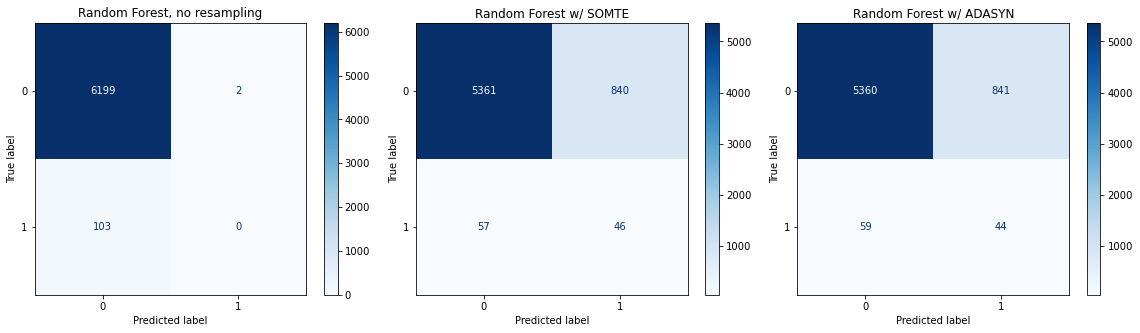

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

cm1 = confusion_matrix(y_test, pred_gb)

cm2 = confusion_matrix(y_test, pred_gb_smo)

cm3 = confusion_matrix(y_test, pred_gb_ada)

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1,cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)
cm3_dis = ConfusionMatrixDisplay(cm3).plot(ax=ax3, cmap=plt.cm.Blues)

ax1.set_title('Random Forest, no resampling')
ax2.set_title("Random Forest w/ SOMTE")
ax3.set_title('Random Forest w/ ADASYN')

plt.subplots_adjust(wspace=0.08)

plt.show()

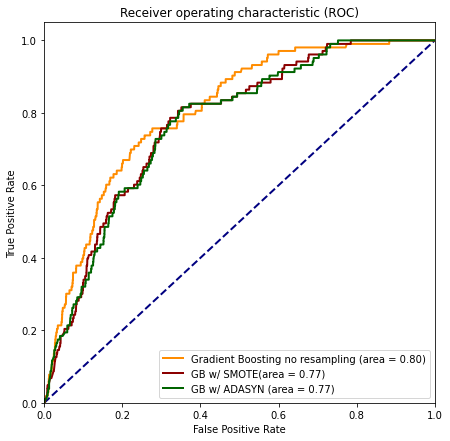

In [35]:
fig = plt.figure(figsize=(7,7))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

fpr, tpr, _ = roc_curve(y_test, prob_gb)
auc = roc_auc_score(y_test, prob_gb)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Gradient Boosting no resampling (area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_gb_smo)
auc = roc_auc_score(y_test, prob_gb_smo)
plt.plot(fpr, tpr, color='darkred', lw=lw, label='GB w/ SMOTE(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_gb_ada)
auc = roc_auc_score(y_test, prob_gb_ada)
plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='GB w/ ADASYN (area = %0.2f)' % auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [36]:
print('No resampling')
model_cv(gb)
print('')
print('SMOTE')
model_cv_smo(gb_smo)
print('')
print('ADASYN')
model_cv_ada(gb_ada)

No resampling
GradientBoostingClassifier(random_state=2) no resampling
The scores are [0.78402658 0.73632001 0.7491464  0.75298517 0.74324705]
The mean is 0.7531450444021649
The STD is 0.016436154025344353

SMOTE
GradientBoostingClassifier(random_state=2) w/ SMOTE
The scores are [0.94542347 0.96190511 0.95883174 0.95736354 0.95958849]
The mean is 0.9566224693801203
The STD is 0.00578880479492734

ADASYN
GradientBoostingClassifier(random_state=2) w/ ADASYN
The scores are [0.94223048 0.94468874 0.95180323 0.94282625 0.94125395]
The mean is 0.9445605292641843
The STD is 0.003790606694667828


array([0.94223048, 0.94468874, 0.95180323, 0.94282625, 0.94125395])

In [37]:
skf = StratifiedKFold(n_splits=5)
print('With Stratified K Fold CV')
print('')
print('No resampling')
model_cv(gb,cv=skf)
print('')
print('SMOTE')
model_cv_smo(gb_smo, cv=skf)
print('')
print('ADASYN')
model_cv_ada(gb_ada, cv=skf)

With Stratified K Fold CV

No resampling
GradientBoostingClassifier(random_state=2) no resampling
The scores are [0.78402658 0.73632001 0.7491464  0.75298517 0.74324705]
The mean is 0.7531450444021649
The STD is 0.016436154025344353

SMOTE
GradientBoostingClassifier(random_state=2) w/ SMOTE
The scores are [0.94542347 0.96190511 0.95883174 0.95736354 0.95958849]
The mean is 0.9566224693801203
The STD is 0.00578880479492734

ADASYN
GradientBoostingClassifier(random_state=2) w/ ADASYN
The scores are [0.94223048 0.94468874 0.95180323 0.94282625 0.94125395]
The mean is 0.9445605292641843
The STD is 0.003790606694667828


array([0.94223048, 0.94468874, 0.95180323, 0.94282625, 0.94125395])

In [38]:
#took too long, not better than bg and LR or rf

from sklearn.svm import SVC

#svc, pred_svc, prob_svc = classify(SVC(probability=True, random_state=2, n_jobs=-1), X_train, y_train)

#svc_smo, pred_svc_smo, prob_svc_smo= classify(SVC(probability=True, random_state=2, n_jobs=-1), X_smo, y_smo)

#svc_ada, pred_svc_ada, prob_svc_ada= classify(SVC(probability=True, random_state=2, n_jobs=-1), X_ada, y_ada)


In [39]:
#print('Regular')
#print(classification_report(y_test, y_pred_svc),'')
#print('SMOTE')
#print(classification_report(y_test, y_pred_svc_smo),'')
#print('ADASYN')
#print(classification_report(y_test, y_pred_svc_ada),'')

# Next Steps

 - Remove deaths?
 - Threshold setting: APPLY AFTER GRIDSEARCH
 - Gridsearch: lr, lr_ada, gb, gb_ada
 - DROP SMO IN FAVOR OF ADA 

## Gridsearch

In [41]:
def gs_tuning(model, params, X=X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=3):
    
    m = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=scoring,
                    n_jobs=n_jobs,
                    cv=cv)
    
    m.fit(X,y)
    
    #pred = m.predict_proba(X_test)[:,1]
    
    print(m.best_params_,)
    print('Train score:', m.best_score_)
    print('Test score:', m.score(X_test, y_test))#roc_auc_score(y_test, pred)
    print(m.best_estimator_)
    

#### Logistic Regression

In [42]:
lr_ = LogisticRegression(random_state=2, n_jobs=-1)

params = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
          'C':[0.01,0.1,1,10], 
          'class_weight':['balanced', None], 
          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} #'l1_ratio':[.1, .3, .5, .7, .9]
          

gs_tuning(lr_, params)

{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Train score: 0.7580523863725915
Test score: 0.7883319790262454
LogisticRegression(C=0.1, n_jobs=-1, random_state=2)


In [43]:
lr_best_ = LogisticRegression(C=0.1, n_jobs=-1, penalty='l2', random_state=2)

lr_best, pred_lr_best, prob_lr_best = classify(lr_best_, X_train, y_train)

model_cv(lr_best_, X_test, y_test)

LogisticRegression(C=0.1, n_jobs=-1, random_state=2) no resampling
The scores are [0.78078163 0.79723502 0.78725038 0.76225038 0.81620968]
The mean is 0.7887454192459131
The STD is 0.017854987240492757


array([0.78078163, 0.79723502, 0.78725038, 0.76225038, 0.81620968])

In [44]:
# getting J statistic threshold

pred_lr_best_thsh = find_threshold(prob_lr_best)

The threshold is 0.018486385786290412


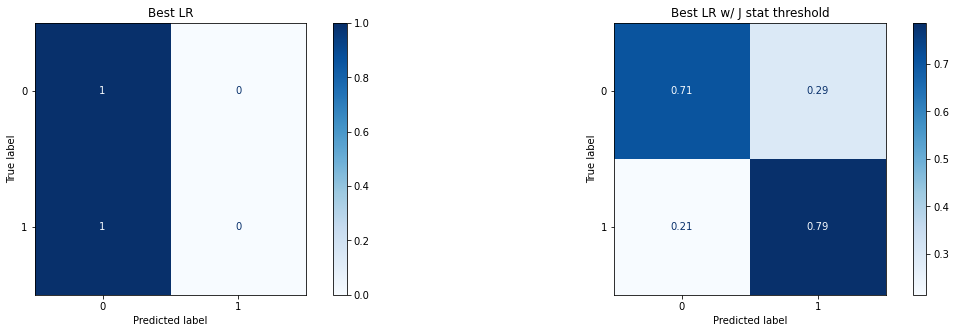

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

cm1 = confusion_matrix(y_test, pred_lr_best, normalize='true')

cm2 = confusion_matrix(y_test, pred_lr_best_thsh, normalize='true')

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1,cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)

ax1.set_title('Best LR')
ax2.set_title("Best LR w/ J stat threshold")

plt.subplots_adjust(wspace=0.08)

plt.show()

#### Logistic Regression SMOTE

In [53]:
lr_ = LogisticRegression(random_state=2, n_jobs=-1)

params = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
          'C':[0.01,0.1,1,10], 
          'class_weight':['balanced', None], 
          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'l1_ratio':[.1, .3, .5, .7, .9]} #
          

gs_tuning(lr_, params, X=X_smo, y=y_smo)

{'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0.7, 'penalty': 'elasticnet', 'solver': 'saga'}
Train score: 0.799054229842934
Test score: 0.793293596554267
LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.7, n_jobs=-1,
                   penalty='elasticnet', random_state=2, solver='saga')


C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [54]:
lr_best_smo_ = LogisticRegression(C=0.1, 
                                  class_weight='balanced', 
                                  l1_ratio=0.7, 
                                  n_jobs=-1,
                                  penalty='elasticnet', 
                                  random_state=2, 
                                  solver='saga')

lr_best_smo, pred_lr_best_smo, prob_lr_best_smo = classify(lr_best_smo_, X_smo, y_smo)

model_cv(lr_best_smo, X_test, y_test)

C:\Users\2bogu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.7, n_jobs=-1,
                   penalty='elasticnet', random_state=2, solver='saga') no resampling
The scores are [0.75044319 0.76397849 0.74769585 0.69569892 0.77685484]
The mean is 0.7469342603148197
The STD is 0.027653929789859817


array([0.75044319, 0.76397849, 0.74769585, 0.69569892, 0.77685484])

In [55]:
pred_lr_best_smo_thsh = find_threshold(prob_lr_best_smo)

The threshold is 0.5534279023855007


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

cm1 = confusion_matrix(y_test, pred_lr_best_smo)

cm2 = confusion_matrix(y_test, pred_lr_best_smo_thsh)

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1,cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)

ax1.set_title('Best LR w/ smo')
ax2.set_title("Best LR w/ smo and J stat threshold")

plt.subplots_adjust(wspace=0.08)

plt.show()

#### Logistic Regression ADASYN ?

In [52]:
lr_ = LogisticRegression(random_state=2, n_jobs=-1)

params = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
          'C':[0.01,0.1,1,10], 
          'class_weight':['balanced', None], 
          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} #'l1_ratio':[.1, .3, .5, .7, .9]
          

gs_tuning(lr_,params,X=X_ada,y=y_ada)


{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
Train score: 0.7839241585494451
Test score: 0.7924512645157452
LogisticRegression(C=0.1, n_jobs=-1, random_state=2, solver='newton-cg')


In [56]:
lr_best_ada_ = LogisticRegression(C=0.1, n_jobs=-1, random_state=2, solver='newton-cg')

lr_best_ada, pred_lr_best_ada, prob_lr_best_ada = classify(lr_best_ada_, X_ada, y_ada)

model_cv(lr_best_ada, X_test, y_test)

LogisticRegression(C=0.1, n_jobs=-1, random_state=2, solver='newton-cg') no resampling
The scores are [0.78078163 0.79723502 0.78725038 0.76225038 0.81620968]
The mean is 0.7887454192459131
The STD is 0.017854987240492757


array([0.78078163, 0.79723502, 0.78725038, 0.76225038, 0.81620968])

In [57]:
pred_lr_best_ada_thsh = find_threshold(prob_lr_best_ada)

The threshold is 0.5258671759359254


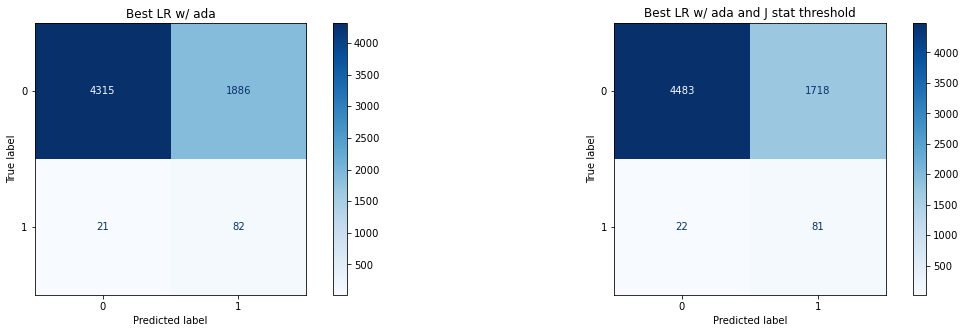

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

cm1 = confusion_matrix(y_test, pred_lr_best_ada)

cm2 = confusion_matrix(y_test, pred_lr_best_ada_thsh)

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1,cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)

ax1.set_title('Best LR w/ ada')
ax2.set_title("Best LR w/ ada and J stat threshold")

plt.subplots_adjust(wspace=0.08)

plt.show()

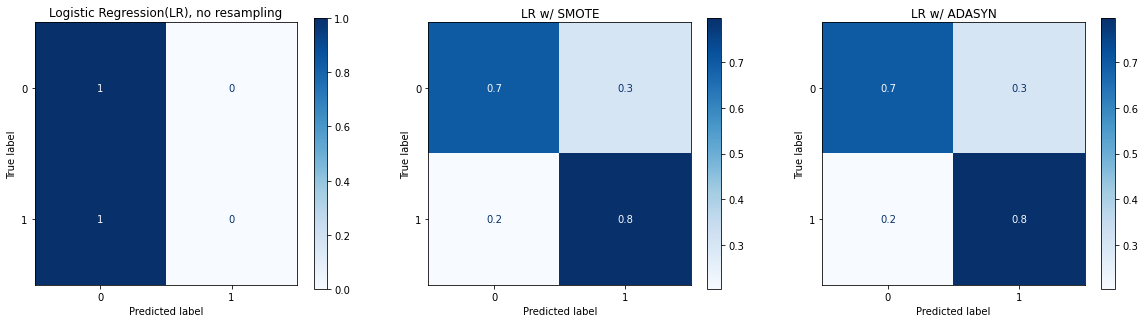

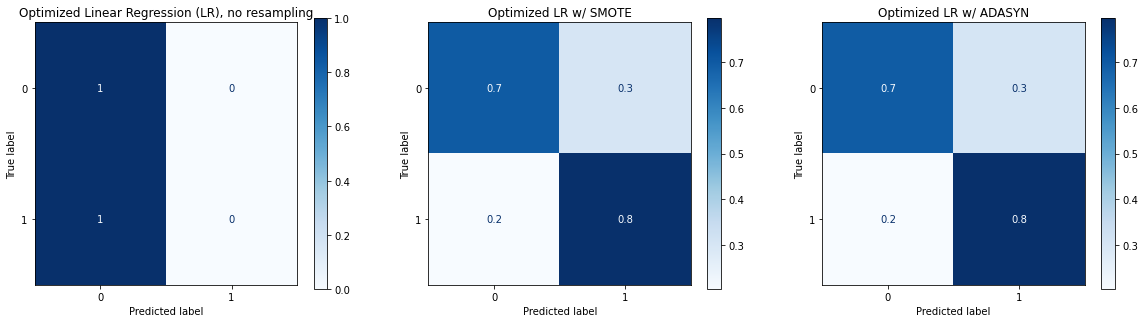

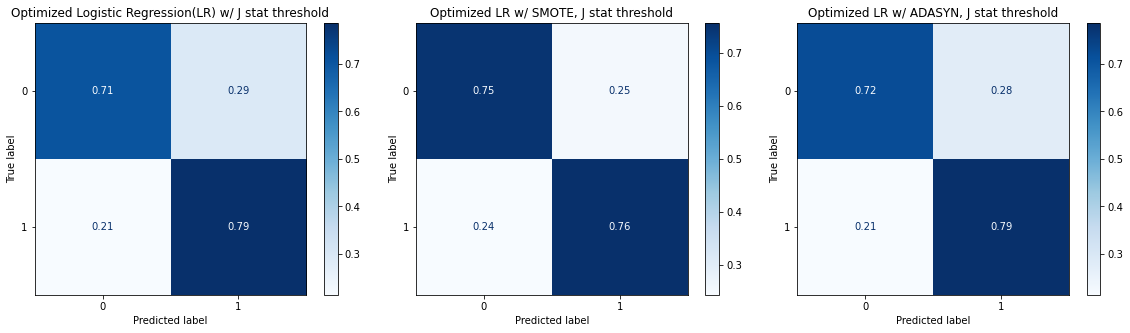

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5)) #, 

cm1 = confusion_matrix(y_test, pred_lr, normalize='true')
cm2 = confusion_matrix(y_test, pred_lr_smo, normalize='true')
cm3 = confusion_matrix(y_test, pred_lr_ada, normalize='true')
cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1, cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)
cm3_dis = ConfusionMatrixDisplay(cm3).plot(ax=ax3, cmap=plt.cm.Blues)
ax1.set_title('Logistic Regression(LR), no resampling')
ax2.set_title('LR w/ SMOTE')
ax3.set_title('LR w/ ADASYN')

fig, (ax4, ax5, ax6)= plt.subplots(1, 3, figsize=(20,5))
cm4 = confusion_matrix(y_test, pred_lr_best, normalize='true')
cm5 = confusion_matrix(y_test, pred_lr_best_smo, normalize='true')
cm6 = confusion_matrix(y_test, pred_lr_best_ada, normalize='true')
cm4_dis = ConfusionMatrixDisplay(cm4).plot(ax=ax4, cmap=plt.cm.Blues)
cm5_dis = ConfusionMatrixDisplay(cm5).plot(ax=ax5, cmap=plt.cm.Blues)
cm6_dis = ConfusionMatrixDisplay(cm6).plot(ax=ax6, cmap=plt.cm.Blues)
ax4.set_title('Optimized Linear Regression (LR), no resampling')
ax5.set_title('Optimized LR w/ SMOTE')
ax6.set_title('Optimized LR w/ ADASYN')

fig, (ax7, ax8, ax9) = plt.subplots(1, 3, figsize=(20,5))
cm7 = confusion_matrix(y_test, pred_lr_best_thsh, normalize='true')
cm8 = confusion_matrix(y_test, pred_lr_best_smo_thsh, normalize='true')
cm9 = confusion_matrix(y_test, pred_lr_best_ada_thsh, normalize='true')
cm7_dis = ConfusionMatrixDisplay(cm7).plot(ax=ax7, cmap=plt.cm.Blues)
cm8_dis = ConfusionMatrixDisplay(cm8).plot(ax=ax8, cmap=plt.cm.Blues)
cm9_dis = ConfusionMatrixDisplay(cm9).plot(ax=ax9, cmap=plt.cm.Blues)
ax7.set_title('Optimized Logistic Regression(LR) w/ J stat threshold')
ax8.set_title('Optimized LR w/ SMOTE, J stat threshold')
ax9.set_title('Optimized LR w/ ADASYN, J stat threshold')

plt.subplots_adjust(wspace=0.08)

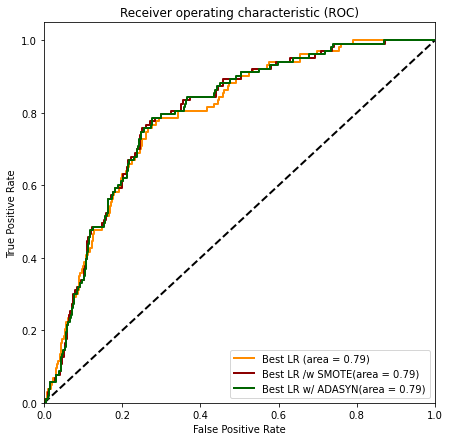

In [62]:
# ADD DOTS FOR THRESHOLDS?

fig = plt.figure(figsize=(7,7))
lw = 2
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')

fpr, tpr, _ = roc_curve(y_test, prob_lr_best)
auc = roc_auc_score(y_test, prob_lr_best)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Best LR (area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_lr_best_smo)
auc = roc_auc_score(y_test, prob_lr_best_smo)
plt.plot(fpr, tpr, color='darkred', lw=lw, label='Best LR /w SMOTE(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_lr_best_ada)
auc = roc_auc_score(y_test, prob_lr_best_ada)
plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='Best LR w/ ADASYN(area = %0.2f)' % auc)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#### Gradient Boosted

In [ ]:
params1 = {'n_estimators': range(20,81,10)}

gb_gs1_ = GridSearchCV(estimator = GradientBoostingClassifier(random_state=2), 
                       param_grid = params1, 
                       scoring='roc_auc',
                       n_jobs=-1, 
                       cv=3)

gb_gs1 = gb_gs1_.fit(X_train, y_train)

gb_gs1.best_params_, gb_gs1.best_score_, gb_gs1.best_estimator_,

In [ ]:
params2 = {'max_depth': range(2,7) ,
           'min_samples_split': np.linspace(.1,1,10)}

gb_gs2 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=2,
                                                              n_estimators=60), 
                       param_grid = params2, 
                       scoring='roc_auc',
                       n_jobs=-1, 
                       cv=3)

gb_gs2.fit(X_train,y_train)

gb_gs2.best_params_, gb_gs2.best_score_, gb_gs2.best_estimator_,

In [ ]:
params3 = {'min_samples_leaf': range(1,7) , 
           'max_features': ['sqrt', 'log2', None]}

gb_gs3 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=2,
                                                             n_estimators=60,
                                                             max_depth=3,
                                                             min_samples_split=0.7), 
                       param_grid = params3, 
                       scoring='roc_auc',
                       n_jobs=-1, 
                       cv=3)

gb_gs3.fit(X_train,y_train)

gb_gs3.best_params_, gb_gs3.best_score_, gb_gs3.best_estimator_,

In [ ]:
params4 = {'subsample':[0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]}

gb_gs4 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=2,
                                                             n_estimators=60,
                                                             max_depth=3,
                                                             min_samples_split=0.7,
                                                             min_samples_leaf=2), 
                       param_grid = params4, 
                       scoring='roc_auc',
                       n_jobs=-1, 
                       cv=3)

gb_gs4.fit(X_train,y_train)

gb_gs4.best_params_, gb_gs4.best_score_, gb_gs4.best_estimator_,

In [ ]:
# tuning learning rate, half the learning rate, double n_estimators
params5 = {'learning_rate':[.1, .05, .025], 'n_estimators':[60,120,240]}

gb_gs5 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=2,
                                                             n_estimators=60,
                                                             max_depth=3,
                                                             min_samples_split=0.7,
                                                             min_samples_leaf=2), 
                       param_grid = params5, 
                       scoring='roc_auc',
                       n_jobs=-1, 
                       cv=3)

gb_gs5.fit(X_train,y_train)

gb_gs5.best_params_, gb_gs5.best_score_, gb_gs5.best_estimator_,


In [64]:
gb_best, pred_gb_best, prob_gb_best = classify(GradientBoostingClassifier(learning_rate=0.05, 
                                                                            min_samples_leaf=2,
                                                                            min_samples_split=0.7, 
                                                                            n_estimators=240,
                                                                            random_state=2), X_train, y_train)

model_cv(gb_best, X_test, y_test)


GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=2,
                           min_samples_split=0.7, n_estimators=240,
                           random_state=2) no resampling
The scores are [0.81071716 0.84082181 0.7750384  0.74253072 0.83266129]
The mean is 0.800353878184062
The STD is 0.03680546422761836


array([0.81071716, 0.84082181, 0.7750384 , 0.74253072, 0.83266129])

In [78]:
from sklearn.metrics import make_scorer

def test_score(model, X, y): 
    
    model.fit(X,y)
    prob = model.predict_proba(X_test)[:,1]
    
    return roc_auc_score(y_test, prob) # tests against probs from on of the folds, not the whole set refit

my_scorer = make_scorer(test_score, needs_proba=True)

In [74]:
params1 = {'n_estimators': range(50,81,10)} # how do I get gridsearch to care about test score to stop overfitting?

gs_tuning(GradientBoostingClassifier(random_state=2), 
          params1, 
          X=X_smo, 
          y=y_smo)

{'n_estimators': 80}
Train score: 0.9522758149744668
Test score: 0.7788690518128144
GradientBoostingClassifier(n_estimators=80, random_state=2)


In [79]:
params1 = {'n_estimators': range(50,81,10)} # how do I get gridsearch to care about test score to stop overfitting?

gs_tuning(GradientBoostingClassifier(random_state=2),
          params1,
          scoring=test_score, 
          X=X_smo, 
          y=y_smo)

{'n_estimators': 50}
Train score: 0.7848919346446367
Test score: 0.9150630261639604
GradientBoostingClassifier(n_estimators=50, random_state=2)


#### Gradient Boosted SMOTE

In [ ]:
params1 = {'n_estimators': range(20,81,10)}

gs_tuning(GradientBoostingClassifier(random_state=2), 
          params1, 
          X=X_smo, 
          y=y_smo)

In [80]:
params1 = {'n_estimators': [79]} # how do I get gridsearch to care about test score to stop overfitting?

gs_tuning(GradientBoostingClassifier(random_state=2), 
          params1, 
          X=X_smo, 
          y=y_smo)

{'n_estimators': 79}
Train score: 0.9520405544160081
Test score: 0.7792949148508774
GradientBoostingClassifier(n_estimators=79, random_state=2)


In [ ]:
params2 = {'max_depth': range(2,6) ,
           'min_samples_split': [.9]} #np.linspace(.05,.1,1)

gs_tuning(GradientBoostingClassifier(n_estimators=79, 
                                     random_state=2), 
          params2, 
          X=X_smo, 
          y=y_smo)

In [ ]:
params3 = {'min_samples_leaf': [750] , 
           'max_features': ['sqrt']}

gs_tuning(GradientBoostingClassifier(n_estimators=79,
                                     min_samples_split=0.9,
                                     random_state=2), 
          params3, 
          X=X_smo, 
          y=y_smo)

In [ ]:
params3 = {'min_samples_leaf': [680] , 
           'max_features': ['sqrt'],
          'subsample': [1.0]}

gs_tuning(GradientBoostingClassifier(n_estimators=79,
                                     min_samples_split=0.9,
                                     random_state=2), 
          params3, 
          X=X_smo, 
          y=y_smo)

In [ ]:
params5 = {'learning_rate':[.5], 'n_estimators':[79]}

gs_tuning(GradientBoostingClassifier(max_features='sqrt', 
                                     min_samples_leaf=680,
                                     min_samples_split=0.9, 
                                     n_estimators=79,
                                     random_state=2), 
          params5, 
          X=X_smo, 
          y=y_smo)

In [ ]:
params5 = {'learning_rate':[.05], 'n_estimators':[158]}

gs_tuning(GradientBoostingClassifier(max_features='sqrt', 
                                     min_samples_leaf=680,
                                     min_samples_split=0.9, 
                                     n_estimators=79,
                                     random_state=2), 
          params5, 
          X=X_smo, 
          y=y_smo)

In [ ]:
params5 = {'learning_rate':[.025], 'n_estimators':[316]}

gs_tuning(GradientBoostingClassifier(max_features='sqrt', 
                                     min_samples_leaf=680,
                                     min_samples_split=0.9, 
                                     n_estimators=79,
                                     random_state=2), 
          params5, 
          X=X_smo, 
          y=y_smo)

In [63]:
gb_best_smo, pred_gb_best_smo, prob_gb_best_smo = classify(GradientBoostingClassifier(max_features='sqrt', 
                                                                                         min_samples_leaf=680,
                                                                                         min_samples_split=0.9, 
                                                                                         n_estimators=79,
                                                                                         random_state=2),
                                                            X_smo,
                                                            y_smo)

model_cv(gb_best_smo, X_test, y_test)

GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=680,
                           min_samples_split=0.9, n_estimators=79,
                           random_state=2) no resampling
The scores are [0.77624899 0.7953533  0.79552611 0.74249232 0.82592742]
The mean is 0.7871096295787426
The STD is 0.02740172966413836


array([0.77624899, 0.7953533 , 0.79552611, 0.74249232, 0.82592742])

#### Gradient Boosting ADA

In [71]:
params1 = {'n_estimators': range(20,81,10)}

gs_tuning(GradientBoostingClassifier(random_state=2),
         params1,
         X=X_ada,
         y=y_ada)

{'n_estimators': 80}
Train score: 0.9366617783259622
Test score: 0.774594764702843
GradientBoostingClassifier(n_estimators=80, random_state=2)


In [72]:
params2 = {'max_depth': range(2,6) ,
           'min_samples_split': np.linspace(.1,1,20)}

gs_tuning(GradientBoostingClassifier(n_estimators=80, random_state=2),
         params2,
         X=X_ada,
         y=y_ada)

{'max_depth': 5, 'min_samples_split': 0.1}
Train score: 0.9446941408114102
Test score: 0.764111801572875
GradientBoostingClassifier(max_depth=5, min_samples_split=0.1, n_estimators=80,
                           random_state=2)


In [65]:
pred_gb_best_thsh = find_threshold(prob_gb_best)

pred_gb_best_smo_thsh = find_threshold(prob_gb_smo)

The threshold is 0.016926820941796705
The threshold is 0.220580450885498


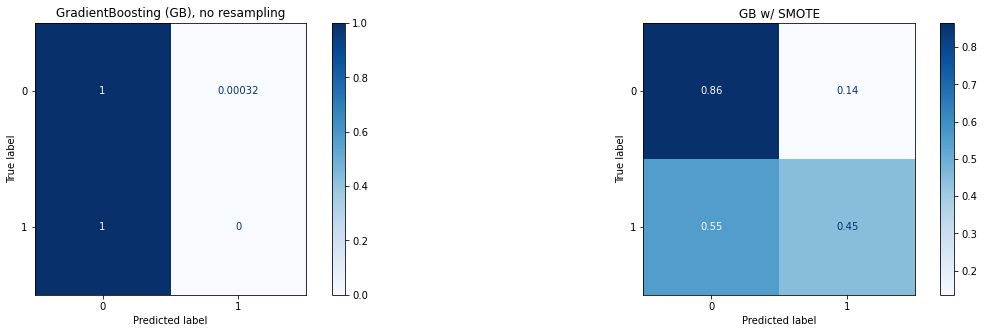

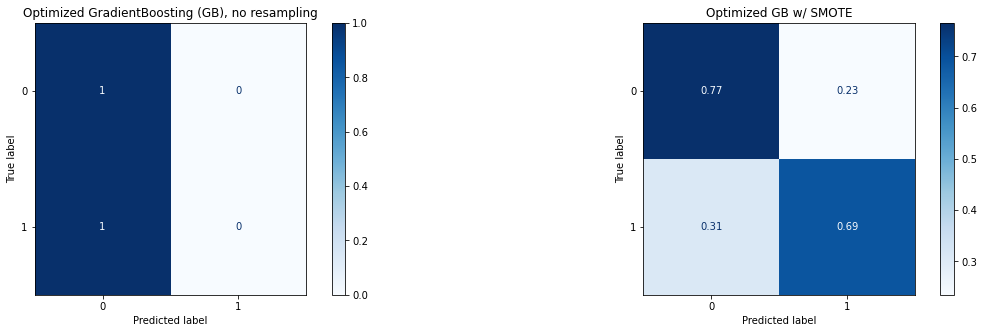

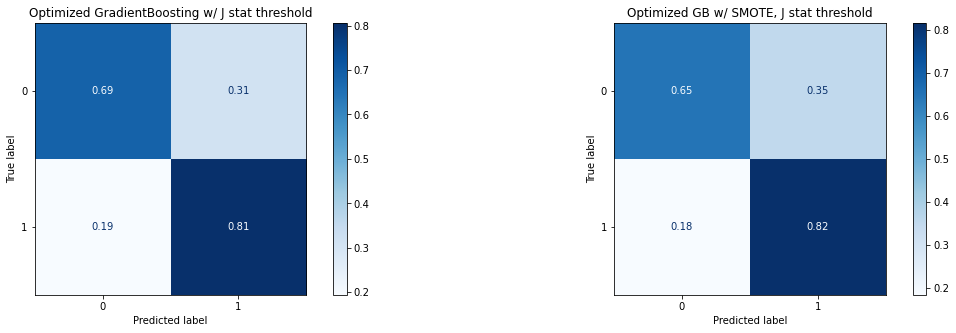

In [69]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5)) #, 

cm1 = confusion_matrix(y_test, pred_gb, normalize='true')
cm2 = confusion_matrix(y_test, pred_gb_smo, normalize='true')
cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1, cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm2).plot(ax=ax2, cmap=plt.cm.Blues)
ax1.set_title('GradientBoosting (GB), no resampling')
ax2.set_title('GB w/ SMOTE')

fig, (ax4, ax5) = plt.subplots(1,2, figsize=(20,5))
cm4 = confusion_matrix(y_test, pred_gb_best, normalize='true')
cm5 = confusion_matrix(y_test, pred_gb_best_smo, normalize='true')
cm4_dis = ConfusionMatrixDisplay(cm4).plot(ax=ax4, cmap=plt.cm.Blues)
cm5_dis = ConfusionMatrixDisplay(cm5).plot(ax=ax5, cmap=plt.cm.Blues)
ax4.set_title('Optimized GradientBoosting (GB), no resampling')
ax5.set_title('Optimized GB w/ SMOTE')

fig, (ax7, ax8) = plt.subplots(1,2, figsize=(20,5))
cm7 = confusion_matrix(y_test, pred_gb_best_thsh, normalize='true')
cm8 = confusion_matrix(y_test, pred_gb_best_smo_thsh, normalize='true')
cm7_dis = ConfusionMatrixDisplay(cm7).plot(ax=ax7, cmap=plt.cm.Blues)
cm8_dis = ConfusionMatrixDisplay(cm8).plot(ax=ax8, cmap=plt.cm.Blues)
ax7.set_title('Optimized GradientBoosting w/ J stat threshold')
ax8.set_title('Optimized GB w/ SMOTE, J stat threshold')

plt.subplots_adjust(wspace=0.08)



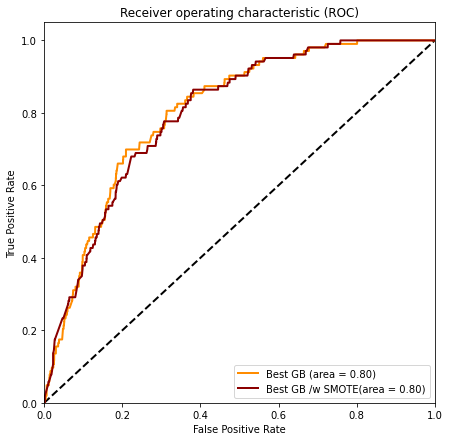

In [70]:
fig = plt.figure(figsize=(7,7))
lw = 2
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')

fpr, tpr, _ = roc_curve(y_test, prob_gb_best)
auc = roc_auc_score(y_test, prob_gb_best)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Best GB (area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, prob_gb_best_smo)
auc = roc_auc_score(y_test, prob_gb_best_smo)
plt.plot(fpr, tpr, color='darkred', lw=lw, label='Best GB /w SMOTE(area = %0.2f)' % auc)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
models = [clf, clf_smo, gb, gb_smo]

for m in models:
    feature_importance = m.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
    sorted_idx = np.argsort(feature_importance)[:30]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(m)
    plt.show()